Text(0, 0.5, 'Percentage Left-handedness')

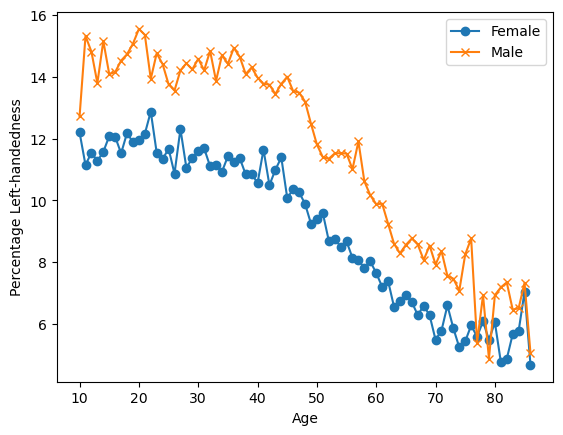

In [1]:
# Task 1: Load the handedness data and create a scatter plot

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
data_url_1 = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
lefthanded_data = pd.read_csv(data_url_1)

# Plot male and female left-handedness rates vs. age
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(lefthanded_data['Age'], lefthanded_data['Female'], label='Female', marker='o')
ax.plot(lefthanded_data['Age'], lefthanded_data['Male'], label='Male', marker='x')
ax.legend()
ax.set_xlabel("Age")
ax.set_ylabel("Percentage Left-handedness")

Text(0, 0.5, 'Mean Left-handedness')

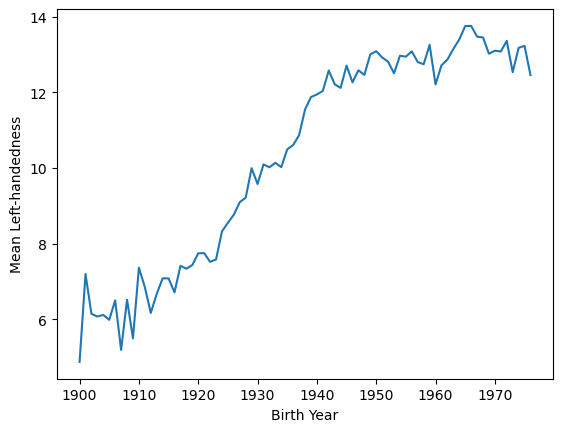

In [2]:
# Task 2: Add birth year and mean left-handedness columns, then plot mean vs. birth year

lefthanded_data['Birth_year'] = 1986 - lefthanded_data['Age']
lefthanded_data['Mean_lh'] = (lefthanded_data['Female'] + lefthanded_data['Male']) / 2

fig, ax = plt.subplots()
ax.plot(lefthanded_data['Birth_year'], lefthanded_data['Mean_lh'])
ax.set_xlabel("Birth Year")
ax.set_ylabel("Mean Left-handedness")

In [3]:
# Task 3: Function to calculate P(LH | A)

def P_lh_given_A(ages_of_death, study_year=1990):
    early_1900s_rate = lefthanded_data.tail(10)['Mean_lh'].mean() / 100
    late_1900s_rate = lefthanded_data.head(10)['Mean_lh'].mean() / 100
    middle_rates = lefthanded_data.loc[lefthanded_data['Birth_year'].isin(study_year - ages_of_death)]['Mean_lh'] / 100
    youngest_age = study_year - 1986 + 10  
    oldest_age = study_year - 1986 + 86  
    P_return = np.zeros(ages_of_death.shape)  
    
    P_return[ages_of_death > oldest_age] = late_1900s_rate
    P_return[ages_of_death < youngest_age] = early_1900s_rate
    
    middle_indices = np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))
    P_return[middle_indices] = middle_rates.values[:sum(middle_indices)]
    
    return P_return

In [4]:
# Define some ages of death
ages_of_death = np.array([30, 50, 70])

# Call the function with the ages of death
probabilities = P_lh_given_A(ages_of_death)

# Print the probabilities
print(probabilities)

[0.12210316 0.11946389 0.0774286 ]


Text(0, 0.5, 'Number of Deaths')

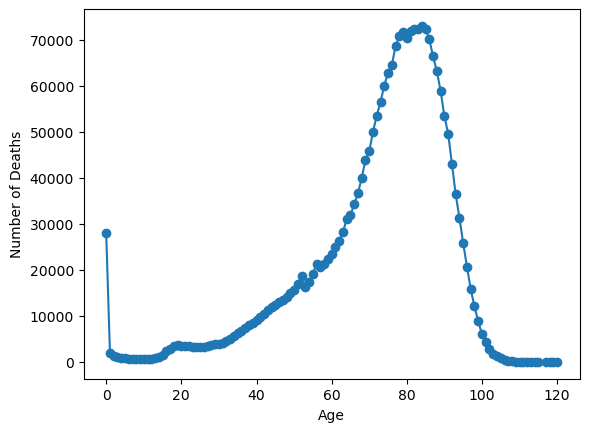

In [5]:
# Task 4: Load death distribution data and plot it

data_url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"
death_distribution_data = pd.read_csv(data_url_2, sep='\t', skiprows=[1])
death_distribution_data = death_distribution_data.dropna(subset=['Both Sexes'])

fig, ax = plt.subplots()
ax.plot(death_distribution_data['Age'], death_distribution_data['Both Sexes'], marker='o')
ax.set_xlabel("Age")
ax.set_ylabel("Number of Deaths")

In [6]:
# Task 5: Function to calculate P(LH)

def P_lh(death_distribution_data, study_year=1990):
    p_list = P_lh_given_A(death_distribution_data['Age'], study_year)
    p = (p_list * death_distribution_data['Both Sexes']).sum()
    return p / death_distribution_data['Both Sexes'].sum()

print("Probability of being left-handed:", P_lh(death_distribution_data))

Probability of being left-handed: 0.08424672059807686


In [7]:
# Task 6: Function to calculate P(A | LH)

def P_A_given_lh(ages_of_death, death_distribution_data, study_year=1990):
    # Interpolate death distribution data to cover the range of ages from 6 to 115
    interpolated_distribution = np.interp(ages_of_death, death_distribution_data['Age'], death_distribution_data['Both Sexes'])
    
    # Normalize the interpolated distribution to sum to 1
    interpolated_distribution /= interpolated_distribution.sum()
    
    # Calculate P(LH), P(LH | A), and P(A | LH)
    P_left = P_lh(death_distribution_data, study_year)
    P_lh_A = P_lh_given_A(ages_of_death, study_year)
    P_A_given_lh = P_lh_A * interpolated_distribution / P_left
    
    return P_A_given_lh

probabilities = P_A_given_lh(ages_of_death, death_distribution_data)
print(probabilities)

[0.08870058 0.33874745 0.64326866]


In [8]:
# Task 7: Function to calculate P(A | RH)

def P_A_given_rh(ages_of_death, death_distribution_data, study_year=1990):
    # Interpolate death distribution data to cover the range of ages from 6 to 115
    interpolated_distribution = np.interp(ages_of_death, death_distribution_data['Age'], death_distribution_data['Both Sexes'])
    
    # Normalize the interpolated distribution to sum to 1
    interpolated_distribution /= interpolated_distribution.sum()
    
    # Calculate P(RH), P(RH | A), and P(A | RH)
    P_right = 1 - P_lh(death_distribution_data, study_year)
    P_rh_A = 1 - P_lh_given_A(ages_of_death, study_year)
    P_A_given_rh = P_rh_A * interpolated_distribution / P_right
    
    return P_A_given_rh

# Example usage
death_distribution_data = {
    'Age': np.array([20, 30, 40]),
    'Both Sexes': np.array([1000, 900, 800])
}
left_handed_probability = P_A_given_lh(ages_of_death, death_distribution_data)
right_handed_probability = P_A_given_rh(ages_of_death, death_distribution_data)
print(left_handed_probability)
print(right_handed_probability)

[0.462095   0.35163861 0.16279208]
[0.42429023 0.33099562 0.24771199]


Text(0, 0.5, 'Probability')

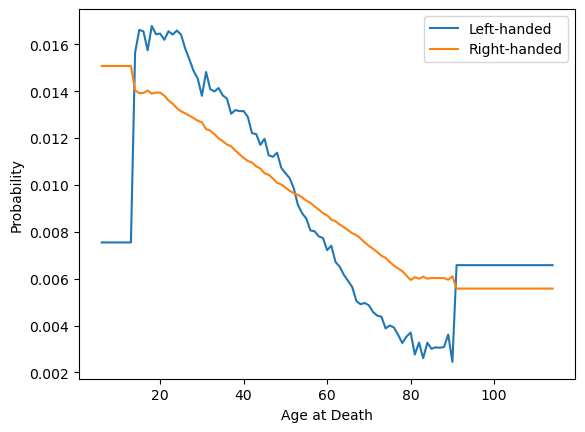

In [9]:
# Task 8: Plot P(A | LH) and P(A | RH)

ages = np.arange(6, 115, 1)
left_handed_probability = P_A_given_lh(ages, death_distribution_data)
right_handed_probability = P_A_given_rh(ages, death_distribution_data)

fig, ax = plt.subplots()
ax.plot(ages, left_handed_probability, label="Left-handed")
ax.plot(ages, right_handed_probability, label="Right-handed")
ax.legend()
ax.set_xlabel("Age at Death")
ax.set_ylabel("Probability")

In [10]:
# Task 9: Find mean age at death for left-handers and right-handers

average_lh_age = np.nansum(ages * left_handed_probability)
average_rh_age = np.nansum(ages * right_handed_probability)

print("Average age at death for left-handers:", round(average_lh_age, 1))
print("Average age at death for right-handers:", round(average_rh_age, 1))
print("Difference in average ages:", round(average_rh_age - average_lh_age, 1))

Average age at death for left-handers: 46.8
Average age at death for right-handers: 49.3
Difference in average ages: 2.5


In [11]:
# Task 10: Repeat calculations for 2018

left_handed_probability_2018 = P_A_given_lh(ages, death_distribution_data, study_year=2018)
right_handed_probability_2018 = P_A_given_rh(ages, death_distribution_data, study_year=2018)

average_lh_age_2018 = np.nansum(ages * left_handed_probability_2018)
average_rh_age_2018 = np.nansum(ages * right_handed_probability_2018)

print("Average age at death for left-handers in 2018:", round(average_lh_age_2018, 1))
print("Average age at death for right-handers in 2018:", round(average_rh_age_2018, 1))
print("Difference in average ages in 2018:", round(average_rh_age_2018 - average_lh_age_2018, 1))

Average age at death for left-handers in 2018: 51.1
Average age at death for right-handers in 2018: 48.8
Difference in average ages in 2018: -2.3
